<a href="https://colab.research.google.com/github/leaf7823/hosripo/blob/master/ieee_lgb_bayesian_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----------
**IEEE Fraud Detection - Bayesian optimization - LGB**
=====================================

***Vincent Lugat***

*July 2019*

----------

![](https://image.noelshack.com/fichiers/2019/29/2/1563297157-cis-logo.png)

- <a href='#1'>1. Libraries and Data</a>  
- <a href='#2'>2. Bayesian Optimisation </a> 
- <a href='#3'>3. LGB + best hyperparameters</a>
- <a href='#4'>4. Features importance</a>
- <a href='#4'>5. Submission</a>

# <a id='1'>1. Librairies and data</a> 

In [0]:
#  Libraries
import numpy as np 
import pandas as pd 
# Data processing, metrics and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from bayes_opt import BayesianOptimization
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc
from sklearn import metrics
from sklearn import preprocessing
# Lgbm
import lightgbm as lgb
# Suppr warning
import warnings
warnings.filterwarnings("ignore")

import itertools
from scipy import interp

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## DATASETS

In [0]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')
sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

## MERGE, MISSING VALUE, FILL NA

In [0]:
# merge 
train_df = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test_df = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print("Train shape : "+str(train_df.shape))
print("Test shape  : "+str(test_df.shape))

Train shape : (590540, 433)
Test shape  : (506691, 432)


In [0]:
pd.set_option('display.max_columns', 500)

In [0]:
# GPreda, missing data
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [0]:
display(missing_data(train_df), missing_data(test_df))

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Total,0,0,0,0,0,8933,1565,1577,4259,1571,65706,65706,352271,552913,94456,453249,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1269,280797,262878,168922,309841,517353,551623,515614,515614,76022,279287,525823,528588,528353,89113,271100,271100,271100,281444,350482,169360,346265,346252,346252,279287,279287,279287,279287,279287,279287,279287,279287,279287,279287,279287,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,76073,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,168969,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,77096,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,89164,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,314,508595,508595,508595,508595,508595,508589,508589,508589,508595,508595,508595,508595,508589,508589,508589,508595,508595,508595,508595,508595,508595,508589,508589,508595,508595,508595,508589,508589,508589,450909,450909,450721,450721,450721,450909,450909,450721,450721,450909,450909,450909,450909,450721,450909,450909,450909,450721,450721,450909,450909,450721,450721,450909,450909,450909,450909,450721,450721,450909,450721,450721,450909,450721,450721,450909,450909,450909,450909,450909,450909,450721,450721,450721,450909,450909,450909,450909,450909,450909,460110,460110,460110,449124,449124,449124,460110,460110,460110,460110,449124,460110,460110,460110,460110,460110,460110,449124,460110,460110,460110,449124,449124,460110,460110,460110,460110,460110,449124,460110,460110,460110,460110,449124,449124,460110,460110,460110,449124,449124,460110,460110,449124,460110,4601

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Total,0,0,0,0,8654,3002,3086,4547,3007,65609,65609,291217,470255,69192,370821,3,3,3,3,3,3,3,3,3,3,3,3,4748,3,6031,234769,203142,76851,224375,381908,446558,432353,432353,12545,176518,437437,383307,391497,12069,176639,176639,176639,237745,309632,158939,235018,235004,235004,176518,176518,176518,176518,176518,176518,176518,176518,176518,176518,176518,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,12589,76854,76854,76854,76854,76854,76854,76854,76854,76854,76854,76854,76854,76854,76854,76854,76854,76854,76854,12899,12899,12899,12899,12899,12899,12899,12899,12899,12899,12899,12899,12899,12899,12899,12899,12899,12899,12899,12899,12899,12899,12081,12081,12081,12081,12081,12081,12081,12081,12081,12081,12081,12081,12081,12081,12081,12081,12081,12081,12081,12081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,430906,430906,430906,430906,430906,430636,430636,430636,430906,430906,430906,430906,430636,430636,430636,430906,430906,430906,430906,430906,430906,430636,430636,430906,430906,430906,430636,430636,430636,369957,369957,370316,370316,370316,369957,369957,370316,370316,369957,369957,369957,369957,370316,369957,369957,369957,370316,370316,369957,369957,370316,370316,369957,369957,369957,369957,370316,370316,369957,370316,370316,369957,370316,370316,369957,369957,369957,369957,369957,369957,370316,370316,370316,369957,369957,369957,369957,369957,369957,379963,379963,379963,369375,369375,369375,379963,379963,379963,379963,369375,379963,379963,379963,379963,379963,379963,369375,379963,379963,379963,369375,369375,379963,379963,379963,379963,379963,369375,379963,379963,379963,379963,369375,369375,379963,379963,379963,369375,369375,379963,379963,369375,379963,379963,379963,379963,379963,379963,379963,379963,379963,379963,369375,369375,369375,379963,379963,379963,379963,3799

In [0]:
#fillna
train_df = train_df.fillna(-999)
test_df = test_df.fillna(-999)

In [0]:
del train_transaction, train_identity, test_transaction, test_identity

## ENCODING

In [0]:
# Label Encoding
for f in train_df.columns:
    if  train_df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values) + list(test_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))  
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [0]:
features = list(train_df)
features.remove('isFraud')
target = 'isFraud'

# <a id='2'>2. Bayesian Optimisation</a> 

In [0]:
#cut tr and val
bayesian_tr_idx, bayesian_val_idx = train_test_split(train_df, test_size = 0.3, random_state = 42, stratify = train_df[target])
bayesian_tr_idx = bayesian_tr_idx.index
bayesian_val_idx = bayesian_val_idx.index

In [0]:
#black box LGBM 
def LGB_bayesian(
    learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_samples, 
    min_child_weight,
    subsample, 
    min_data_in_leaf,
    max_depth,
    colsample_bytree,
    reg_alpha,
    reg_lambda
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    

    param = {
              'num_leaves': num_leaves, 
              'min_child_samples': min_child_samples, 
              'min_data_in_leaf': min_data_in_leaf,
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'subsample': subsample, 
              'max_depth': max_depth,
              'colsample_bytree': colsample_bytree,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'objective': 'binary',
              'save_binary': True,
              'seed': 1337,
              'feature_fraction_seed': 1337,
              'bagging_seed': 1337,
              'drop_seed': 1337,
              'data_random_seed': 1337,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'is_unbalance': False,
              'boost_from_average': True,
              'metric':'auc'}    
    
    oof = np.zeros(len(train_df))
    trn_data= lgb.Dataset(train_df.iloc[bayesian_tr_idx][features].values, label=train_df.iloc[bayesian_tr_idx][target].values)
    val_data= lgb.Dataset(train_df.iloc[bayesian_val_idx][features].values, label=train_df.iloc[bayesian_val_idx][target].values)

    clf = lgb.train(param, trn_data,  num_boost_round=50, valid_sets = [trn_data, val_data], verbose_eval=0, early_stopping_rounds = 50)
    
    oof[bayesian_val_idx]  = clf.predict(train_df.iloc[bayesian_val_idx][features].values, num_iteration=clf.best_iteration)  
    
    score = roc_auc_score(train_df.iloc[bayesian_val_idx][target].values, oof[bayesian_val_idx])

    return score

In [0]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (31, 500), 
    'min_data_in_leaf': (20, 200),
    'bagging_fraction' : (0.1,0.9),
    'feature_fraction' : (0.1,0.9),
    'learning_rate': (0.01, 0.3),
    'min_child_weight': (0.00001, 0.01),   
    'min_child_samples':(100, 500), 
    'subsample': (0.2, 0.8),
    'colsample_bytree': (0.4, 0.6), 
    'reg_alpha': (1, 2), 
    'reg_lambda': (1, 2),
    'max_depth':(-1,50),
}

In [0]:
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)

In [0]:
print(LGB_BO.space.keys)

['bagging_fraction', 'colsample_bytree', 'feature_fraction', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_data_in_leaf', 'num_leaves', 'reg_alpha', 'reg_lambda', 'subsample']


In [0]:
init_points = 10
n_iter = 15

In [0]:
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | colsam... | featur... | learni... | max_depth | min_ch... | min_ch... | min_da... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9073   |  0.3996   |  0.5901   |  0.6856   |  0.1836   |  6.957    |  162.4    |  0.000590 |  175.9    |  312.9    |  1.708    |  1.021    |  0.7819   |
|  2        |  0.9425   |  0.766    |  0.4425   |  0.2455   |  0.06319  |  14.52    |  309.9    |  0.004325 |  72.42    |  318.0    |  1.139    |  1.292    |  0.4198   |
|  3        |  0.9153   |  0.4649   |  0.557    |  0.2597   |  0.1591   |  29.21    |  118.6    |  0.006079 |  50.69    |  61.51    |  1.949    |  1.966    |  0.685    |
|  4        |  0.89

In [0]:
LGB_BO.max['target']

0.9584590799402207

In [0]:
LGB_BO.max['params']

{'bagging_fraction': 0.8831783305477362,
 'colsample_bytree': 0.5941836821402656,
 'feature_fraction': 0.8359307480774029,
 'learning_rate': 0.23836691517558517,
 'max_depth': 0.128322416958925,
 'min_child_samples': 105.54076348952397,
 'min_child_weight': 0.005812630846994812,
 'min_data_in_leaf': 23.71996640003482,
 'num_leaves': 496.9273211506215,
 'reg_alpha': 1.229972928485176,
 'reg_lambda': 1.3080809161627962,
 'subsample': 0.4071603440308888}

## CONFUSION MATRIX

In [0]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# <a id='3'>3. LGB + best hyperparameters</a> 

In [0]:
param_lgb = {
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), 
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), 
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_child_weight': LGB_BO.max['params']['min_child_weight'],
        'colsample_bytree' : LGB_BO.max['params']['colsample_bytree'],
        'bagging_fraction': LGB_BO.max['params']['bagging_fraction'], 
        'min_child_samples': LGB_BO.max['params']['min_child_samples'],
        'subsample': LGB_BO.max['params']['subsample'],
        'reg_lambda': LGB_BO.max['params']['reg_lambda'],
        'reg_alpha': LGB_BO.max['params']['reg_alpha'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), 
        'objective': 'binary',
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'boosting_type': 'gbdt',
        'verbose': 1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }

In [0]:
nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(train_df))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

i = 1
for train_idx, valid_idx in skf.split(train_df, train_df.isFraud.values):
    print("\nfold {}".format(i))
    trn_data = lgb.Dataset(train_df.iloc[train_idx][features].values,
                                   label=train_df.iloc[train_idx][target].values
                                   )
    val_data = lgb.Dataset(train_df.iloc[valid_idx][features].values,
                                   label=train_df.iloc[valid_idx][target].values
                                   )   
    
    clf = lgb.train(param_lgb, trn_data, num_boost_round=800, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[valid_idx] = clf.predict(train_df.iloc[valid_idx][features].values) 
    
    predictions += clf.predict(test_df[features]) / nfold
    
    # Scores 
    roc_aucs.append(roc_auc_score(train_df.iloc[valid_idx][target].values, oof[valid_idx]))
    accuracies.append(accuracy_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(train_df.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Roc curve by fold
    fpr, tpr, t = roc_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Features imp
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGB ROC curve by folds')
plt.legend(loc="lower right")
plt.show()

# Confusion maxtrix & metrics
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title= 'LGB Confusion matrix [averaged/folds]')
plt.show()

NameError: ignored

# <a id='4'>4. Features importance</a> 

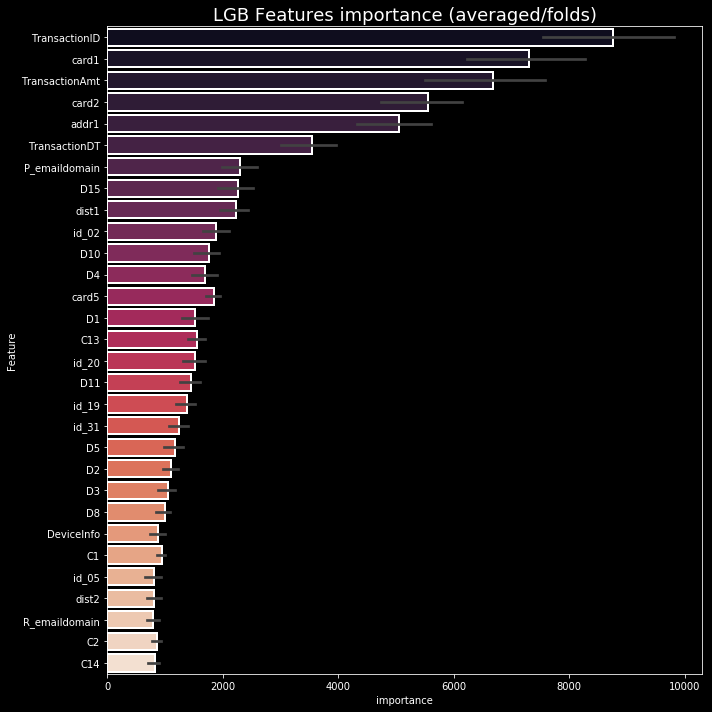

In [0]:
plt.style.use('dark_background')
cols = (feature_importance_df[["Feature", "importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False),
        edgecolor=('white'), linewidth=2, palette="rocket")
plt.title('LGB Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()

# <a id='5'>5. Submission</a> 

In [0]:
sample_submission['isFraud'] = predictions
sample_submission.to_csv('submission_IEEE.csv')